## Method of Regularized Stokeslets: Point-Volume Surface Parameterization 

The following code file contains the implementation of the Method of Regularized Stokeslets (MRS), particularly for the canonical case of solving for the drag force acting on a smooth sphere. The implementation works by first breaking the spherical surface down into a set of equispaced points and then implementing the MRS as per the papers [The Method of Regularized Stokeslets](https://epubs.siam.org/doi/abs/10.1137/S106482750038146X?journalCode=sjoce3) and [The method of regularized Stokeslets in three dimensions: Analysis, validation, and application to helical swimming](https://scholar.archive.org/work/wxryxhn4ijg2fnmkdqo34ddoqm/access/wayback/http://www.math.tulane.edu/~amedovik/publications/CortezFauciMedovikov1.pdf) published by Ricardo Cortez. To understand the following code file, it is important to first understand the basic theory that the MRS is built upon.

**Navier-Stokes Equation:**
$$
\rho \frac{\partial \mathbf{u}}{\partial t} = -\nabla p + \mu \nabla^2 \mathbf{u} + \mathbf{f}
$$

**Stokes Equations:**
$$
\mu \nabla^2 \mathbf{u} - \nabla p + \mathbf{f} = 0 \\
\nabla \cdot \mathbf{u} = 0
$$

First, we must understand that the Stokes equation is a simplification of the well-known Navier-Stokes equations. The Navier-Stokes equation works by building on the Euler equation by adding a term that accounts for the viscosity of the fluid being studied. The Stokes equation works by applying the assumption of a small Reynolds number (Re<<1). This means that the Stokes equation is composed of only linear terms. Not only does this simplify the force calculation itself, but also allows for the principle of superposition to be used when calculating the total force over a given body.

**Governing Equations:**
$$
u(x_{N}) = \sum_{i=1}^{N} F_{i} S(x_{N} - x_{i}) + u_{\infty} \\

u(x_{N}) = \sum_{i=1}^{N} F_{i} M + u_{\infty}
$$

**Boundary Conditions:**
$$
u(x_{i}) = 0 \\
i \epsilon (1, 2, ..., N)
$$

**Blob Function:** 
$$
\phi = \frac{15 \epsilon^4}{8 \pi  (r^2 + \epsilon^2)^{\frac{7}{2}} }
$$


Ultimately, the following implementation will solve the governing equations with the prescribed boundary condition. However, in order to create this implementation, one must first define the cutoff or "blob" function and understand how it helps define the kernel. 

Physically, the simulation environment can be thought of as a sphere fixed in space inside an empty duct, while a uniform, 1D flow of air is traveling across the duct. It is best to conceptualize the sphere as a momentum source in this case. The surface of the sphere is imparting some amount of momentum on the freestream air, and there is an induced velocity response as the flow navigates around the sphere. 

The kernel essentially represents one cell of the surface mesh for the sphere. Our kernel in this case can be thought of as a point on the sphere with an associated volume that encompasses a certain amount of the spherical surface. This type of kernel is also known more generally as a Voronoi cell. The number of these kernels is dependent on the number of points on the sphere, while the size of the associated volume is dependent on the parameter $\epsilon$, which will be defined in the code. For this particular report, the choice of $\epsilon$ will be of the order one and proportional to the radius of the sphere as well as the radius of the kernel. A study will be completed later in the report to show different choices of $\epsilon$ can affect the result.     

It is important to note the properties of the blob function. A blob function can be visualized using two curves, one defining the momentum source and the other defining the velocity response. The curve defining momentum can be any shape; in this case, it is triangular. However, it must equal zero at the x-bounds of negative and positive $\epsilon$. The velocity curve, on the other hand, is parabolic in shape and does not have this range restriction. This graph illustrates the idea that a given kernel can act as a momentum source only over the bounds of the associated volume, while the velocity response might exist beyond these bounds. This concept is important when considering how much or how little to space the placement of the kernels on the sphere.

**S Function:**
$$
S_{ij}(x,x_0) = \frac{1}{8 \pi \mu} (\frac{\delta_{ij} r^2 + 2\epsilon^2}{(r^2 + \epsilon^2)^{\frac{3}{2}}} + \frac{(x_i - x_{0,i})(x_j - x_{0,j})}{(r^2 + \epsilon^2)^{\frac{3}{2}}})
$$

Returning to the governing equation, the blob function, along with the Green's functions G and B, allows for the definition of the S function. When the S function is evaluated over the set of spherical points, it can then be represented as the matrix M, which is a block matrix of size (3N, 3N). Finally, the boundary condition must be applied. In this case, the boundary condition represents the no-slip condition that exists on the surface of the sphere. This conveniently allows us to represent the system in matrix equation form.     

**Simplied Form of Governing Equation:**
$$
-u_{\infty} = M F
$$

However, before we solve this equation for the drag force (F), a set of equispaced points must be defined on the sphere to parameterize the matrix M. This can be done using the algorithm established by Markus Deserno in the paper [How to generate equidistributed points on the surface of a sphere](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf). It must be noted that when using this algorithm, there are certain steps where truncation is required. This means that when the desired N is 100, the actual number of points generated will be 99. However, this discrepancy is accounted for in the code, ensuring that the vectors and matrices that follow are of the correct size for the mathematical operations to proceed accordingly.

**Algorithm for Equispaced Points on a Sphere:**

![Alt text](alg.png)

Now, all of the mathematical tools have been set up in order to solve for the force vector of length 3N. Using superposition, the three components of the force vector can then be added from each point in order to find the total drag force acting on the sphere. This same simplified form of the governing equation can also be used to find the velocity distribution of flow around the sphere, as show later in this report.

In [1]:
''' 
Implementing Method of Regularized Stokeslets (MRS)
'''

def MRS(num_points, eps): 

    # Import Statements 
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    '''Part 1: Setting Points on the Sphere'''

    # Following Algorith for Equispaced Points on a Sphere
    N = num_points  # Number of points on our sphere
    a = 4.0 * np.pi / N  
    d = np.sqrt(a)
    M_theta = int(round(np.pi / d))
    d_theta = np.pi / M_theta
    d_phi = a / d_theta

    sphere_points_list = []
    r = 0.01  # Radius of sphere (meters)

    for m in range(M_theta):
        theta = (np.pi * (m + 0.5)) / M_theta
        M_phi = int(round(((2 * np.pi) * np.sin(theta)) / d_phi))
        for n in range(M_phi):
            phi = (2 * np.pi * n) / M_phi
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            vector = np.array([x, y, z])
            sphere_points_list.append(vector)

    sphere_points = np.array(sphere_points_list)
    N = len(sphere_points) # Reset N to match number of points generated by algorithm 

    '''
    Part 2: Solving for Drag Force 
    '''

    # Building Free Stream Velocity Vector
    u_inf = 1 # Setting magnitude of free stream velocity (m/s)
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec 
    v = vel.reshape(-1, 1)

    # Building S Function (combination of B and G matrices)
    def S_func(x, x0):
        radius = np.linalg.norm(x-x0)
        epsilon = eps * d * r
        p1 = np.eye(3,3) * ((radius**2 + 2*epsilon**2)/(radius**2+epsilon**2)**(3/2))
        p2 = (1/(radius**2+epsilon**2)**(3/2)) * np.outer(x-x0, x-x0)
        S = p1 + p2
        return S

    # Building M Matrix 
    M = np.zeros((3*N,3*N))
    for i in range(N):
        for j in range(N):
            for k in range(3):
                for l in range(3):
                    S = S_func(sphere_points[j], sphere_points[i])
                    M[3*i+k][3*j+l] = S[k][l]

    # Solving for Force Vector
    F = np.linalg.solve(M, v)
    F_matrix = F.reshape(N, 3)
    Fx = np.sum(F_matrix[:, 0])
    Fy = np.sum(F_matrix[:, 1])
    Fz = np.sum(F_matrix[:, 2])
    F_vector = (8*np.pi) * np.array([Fx, Fy, Fz]) # Including 8pi correcting factor 

    return sphere_points, N, r, u_inf, F, F_vector

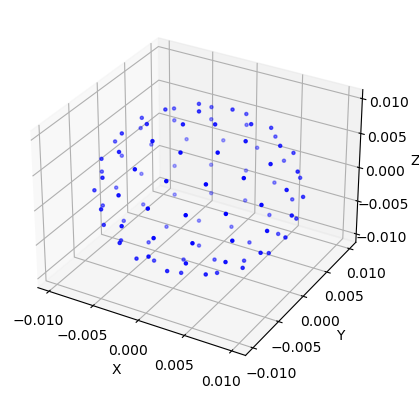

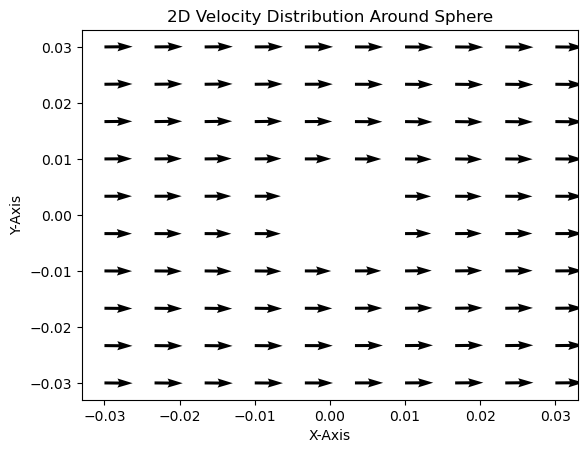

In [2]:
'''
Visualizing Equispaced Points on the Sphere:
'''

# Import Statements 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Make sure definitions match MRS method 
N = 100  
a = 4.0 * np.pi / N  
d = np.sqrt(a) 
r = 0.01

# Calling MRS Function:
sphere_points1, N1, r1, u_inf1, F_unstacked1, F1 = MRS(100, 1.5*d*r)

# Plotting Points: 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x_coords = sphere_points1[:, 0]
y_coords = sphere_points1[:, 1]
z_coords = sphere_points1[:, 2]

ax.scatter(x_coords, y_coords, z_coords, s=5, c='b', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

'''
Visualizing Velocity Flow Around Sphere in 2D:
'''

# Calling MRS Function:
sphere_points2, N2, r2, u_inf2, F_unstacked2, F2 = MRS(100, 1.5*d*r)

# Regular Grid Generation 
L = 1 # Length (meters)
W = 1 # Width (meters)
H = 1 # Height (meters)
Nx = 10
Ny = 10
Nz = 11
Ngrid = Nx*Ny*Nz

x0 = -3*r2; x1 = 3*r2
y0 = -3*r2; y1 = 3*r2
z0 = -3*r2; z1 = 3*r2
dx = (x1-x0) / (Nx - 1)
dy = (y1-y0) / (Ny - 1)
dz = (z1-z0) / (Nz - 1)

# Building S Function (combination of B and G matrices)
def S_func(x, x0):
    radius = np.linalg.norm(x-x0)
    epsilon = 1.5*np.sqrt((4.0 * np.pi) / N2)*r2
    p1 = np.eye(3,3) * ((radius**2 + 2*epsilon**2)/(radius**2+epsilon**2)**(3/2))
    p2 = (1/(radius**2+epsilon**2)**(3/2)) * np.outer(x-x0, x-x0)
    S = p1 + p2
    return S

fv_points = []
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            x_coord = x0 + x * dx
            y_coord = y0 + y * dy
            z_coord = z0 + z * dz
            fv_points.append([x_coord, y_coord, z_coord])
FV_points = np.array(fv_points)

# Reparametrize M Matrix
M_list1 = [] 
M1 = np.zeros((3*Ngrid,3*N2)) 
for i in range(Ngrid):
    for j in range(N2):
        for k in range(3):
            for l in range(3):
                S = S_func(sphere_points2[j], FV_points[i])
                M1[3*i+k][3*j+l] = S[k][l]

# Solving for Velocity Around Sphere
FV_vel = M1 @ F_unstacked2
FV_vel_matrix = np.reshape(FV_vel, (-1, 3))

# Choosing 2D Cross-Section
plane_normal = np.array([0, 0, 1])  # Normal vector of the XY-plane

# Creating a Figure and Axis
fig, ax = plt.subplots()

x_coords = []; y_coords = [];
u = []; v = [];

k = 0
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            x_coord = x0 + x * dx
            y_coord = y0 + y * dy
            z_coord = z0 + z * dz
            radius = np.sqrt(x_coord*x_coord+y_coord*y_coord)
            if radius > r2 and np.abs(z_coord) < 0.5*dz:
                x_coords.append(x_coord)
                y_coords.append(y_coord)
                u.append(FV_vel[3*k+0]+u_inf2)
                v.append(FV_vel[3*k+1])
            k += 1

# Creating Quiver Plot
ax.quiver(x_coords, y_coords, u, v)

# Setting Labels and Title 
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title('2D Velocity Distribution Around Sphere')

# Show the Plot
plt.show()

**Equation for Analytical Solution to Drag Force on a Sphere:**

$$
F = 6 \pi \mu r v 
$$


In order to prove the accuracy of this numerical method, the analytical solution for the drag force on a sphere must be obtained to define the error parameter. The equation shown above represents this analytical solution, which can only be applied to viscous flows where the Reynolds number is small.

In the given equation, the parameter $\mu$ represents the dynamic viscosity of the flow, $v$ denotes the free stream velocity of the flow, and $r$ indicates the radius of the sphere. A function solving this equation is defined below.

In [3]:
'''
Analytical Solution for Flow Around a Sphere
'''

def analytical_solution():
    import numpy as np
    n = 1 # Dynamic Viscosity (Pascal * seconds) 
    r = 0.01 # Radius of Sphere (meters) 
    v = np.array([-1, 0, 0]) # Velocity of Sphere (meters/second) 

    # Low Reynolds Number Stokes Drag Formula  
    F = (6*np.pi)*n*r*v

    return F

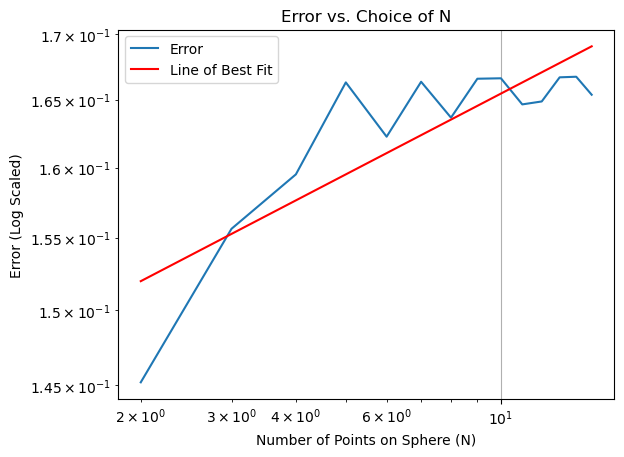

In [4]:
'''
Calculating Error Between MRS and Analytical Solution
'''

# Import Statements 
import numpy as np
import matplotlib.pyplot as plt


# Calculate Error Values
num = 15
err_vals = []
num_vals = []

for i in range(1, num):
    # Make sure definitions match MRS method 
    N = i
    a1 = 4.0 * np.pi / N  
    d1 = np.sqrt(a1) 
    r1 = 0.01

    F_real = analytical_solution()
    sphere_points3, N3, r3, u_inf3, F3, F_est = MRS(i, 1.5*d1*r1)
    error = np.linalg.norm(F_real - F_est)
    err_vals.append(error)
    num_vals.append(i+1)

# Plot the Data
plt.figure()
plt.plot(num_vals, err_vals, label='Error')  

# Log Scale the Axes
plt.xscale('log')  
plt.yscale('log')

# Add Labels and Title
plt.xlabel('Number of Points on Sphere (N)')
plt.ylabel('Error (Log Scaled)')
plt.title('Error vs. Choice of N')
plt.grid(True)

# Add a Line of Best Fit
coefficients = np.polyfit(np.log(num_vals), np.log(err_vals), 1)
poly = np.poly1d(coefficients)
plt.plot(num_vals, np.exp(poly(np.log(num_vals))), label='Line of Best Fit', color='red')

# Show Legend
plt.legend()

# Show Plot
plt.show()    

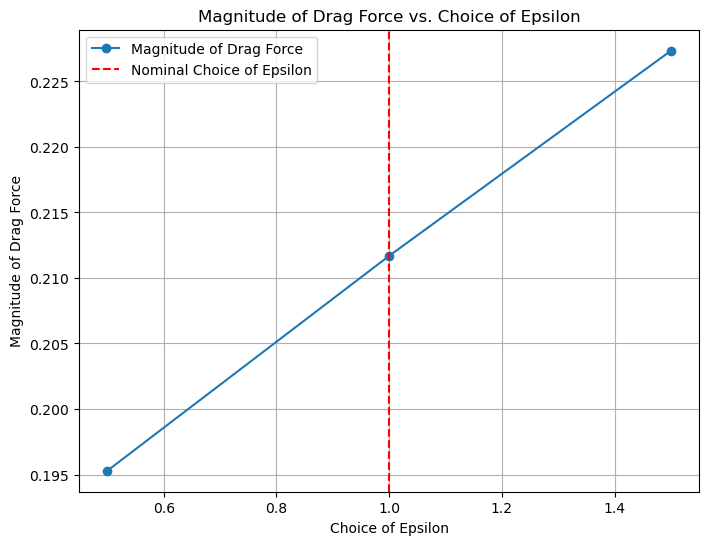

In [5]:
'''
Plotting Force Magnitude Against Choice of Epsilon
'''

eps_values = np.arange(0.5, 2, 0.5)
N = 100

mag_vals = []

for val in eps_values:
    sphere_points4, N4, r4, u_inf4, F_unstacked4, F4 = MRS(N, val)
    mag = np.linalg.norm(F4)
    mag_vals.append(mag)

mag_vals = np.array(mag_vals)

# Point to plot
x_point = 1

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(eps_values, mag_vals, marker='o', linestyle='-', label='Magnitude of Drag Force')
plt.axvline(x=x_point, color='red', linestyle='--', label='Nominal Choice of Epsilon')
plt.xlabel('Choice of Epsilon')
plt.ylabel('Magnitude of Drag Force')
plt.title('Magnitude of Drag Force vs. Choice of Epsilon')
plt.grid(True)
plt.legend()
plt.show()

